In [1]:
# Install dependencies
!pip install pretty_midi kagglehub

# Imports
import pretty_midi
import kagglehub
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Download the dataset (make sure Kaggle API token is setup in your Colab environment)
path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
print("Dataset downloaded at:", path)
midi_path = path

# Known composers list (for extraction)
known_composers = [
    "Bach", "Mozart", "Beethoven", "Chopin", "Tchaikovsky", "Handel", "Schubert",
    "Haydn", "Brahms", "Liszt", "Mendelssohn", "Debussy", "Ravel", "Grieg", "Dvorak",
    "Stravinsky", "Rachmaninoff", "Mahler", "Shostakovich", "Alkan", "Albeniz",
    "Ambroise", "Arensky", "Arndt", "Bacewitz"
]

# Function to load MIDI files safely
def load_midi_files(directory):
    midi_data = []
    bad_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".mid", ".midi")):
                try:
                    full_path = os.path.join(root, file)
                    midi = pretty_midi.PrettyMIDI(full_path)
                    midi_data.append((full_path, file, midi))
                except Exception:
                    bad_files.append(file)
                    continue
    return midi_data, bad_files

# Extract composer from file path
def extract_composer_from_path(full_path):
    parts = os.path.normpath(full_path).split(os.sep)
    for part in reversed(parts[:-1]):
        for composer in known_composers:
            if composer.lower() in part.lower():
                return composer
    return "Unknown"

# Extract features from MIDI data
def extract_features(midi_dataset):
    rows = []
    for full_path, filename, midi in midi_dataset:
        try:
            pitches = []
            durations = []
            for instrument in midi.instruments:
                for note in instrument.notes:
                    pitches.append(note.pitch)
                    durations.append(note.end - note.start)
            if pitches:
                pitch_mean = np.mean(pitches)
                pitch_std = np.std(pitches)
                pitch_min = np.min(pitches)
                pitch_max = np.max(pitches)
                duration_mean = np.mean(durations)
                duration_std = np.std(durations)
                duration_min = np.min(durations)
                duration_max = np.max(durations)
            else:
                pitch_mean = pitch_std = pitch_min = pitch_max = 0
                duration_mean = duration_std = duration_min = duration_max = 0

            duration = midi.get_end_time()
            tempi = midi.get_tempo_changes()[1]

            if len(tempi) > 0:
                tempo_mean = np.mean(tempi)
                tempo_std = np.std(tempi)
            else:
                tempo_mean = tempo_std = 0

            key_number = midi.key_signature_changes[0].key_number if midi.key_signature_changes else -1

            num_instruments = len(midi.instruments)

            notes = [note.pitch for instrument in midi.instruments for note in instrument.notes if not instrument.is_drum]
            avg_pitch = np.mean(notes) if notes else np.nan
            note_density = len(notes) / duration if duration > 0 else 0

            composer = extract_composer_from_path(full_path)

            rows.append({
                'filename': filename,
                'composer': composer,
                'duration': duration,
                'num_instruments': num_instruments,
                'note_count': len(pitches),
                'note_density': note_density,
                'notes': notes,
                'pitch_mean': pitch_mean,
                'pitch_std': pitch_std,
                'pitch_min': pitch_min,
                'pitch_max': pitch_max,
                'avg_pitch': avg_pitch,
                'duration_mean': duration_mean,
                'duration_std': duration_std,
                'duration_min': duration_min,
                'duration_max': duration_max,
                'tempo_mean': tempo_mean,
                'tempo_std': tempo_std,
                'key': key_number
            })

        except Exception as e:
            print(f"Error processing {filename}: {e}")
            continue

    return pd.DataFrame(rows)

Dataset downloaded at: /kaggle/input/midi-classic-music


# Load Dataset

In [3]:
# Load MIDI dataset
midi_dataset, bad_files = load_midi_files(midi_path)
print(f"Loaded {len(midi_dataset)} good MIDI files.")
print(f"Skipped {len(bad_files)} broken files.")

# Extract features
df = extract_features(midi_dataset)

# Filter to desired composers
df = df[df["composer"].isin(["Bach", "Beethoven", "Chopin", "Mozart"])].reset_index(drop=True)
print(df["composer"].value_counts())


Loaded 4625 good MIDI files.
Skipped 87 broken files.
composer
Bach         1024
Mozart        256
Beethoven     212
Chopin        136
Name: count, dtype: int64


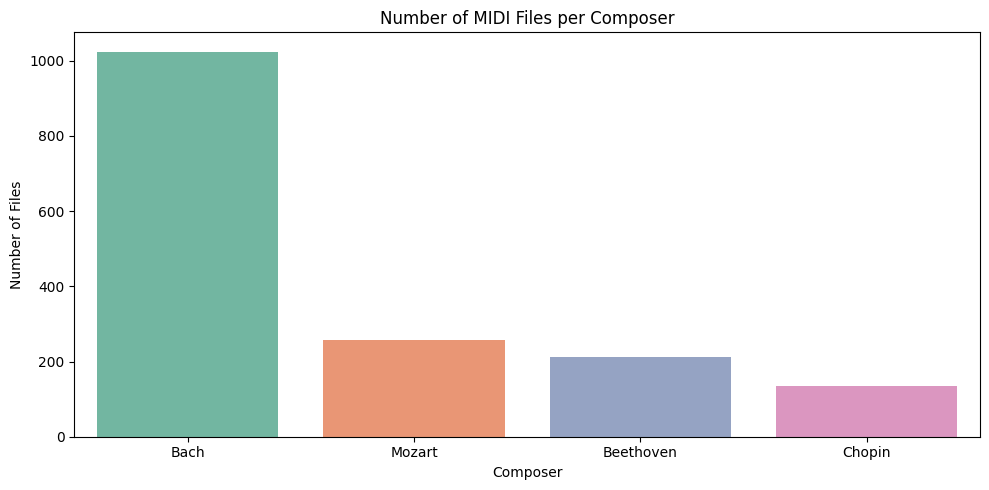

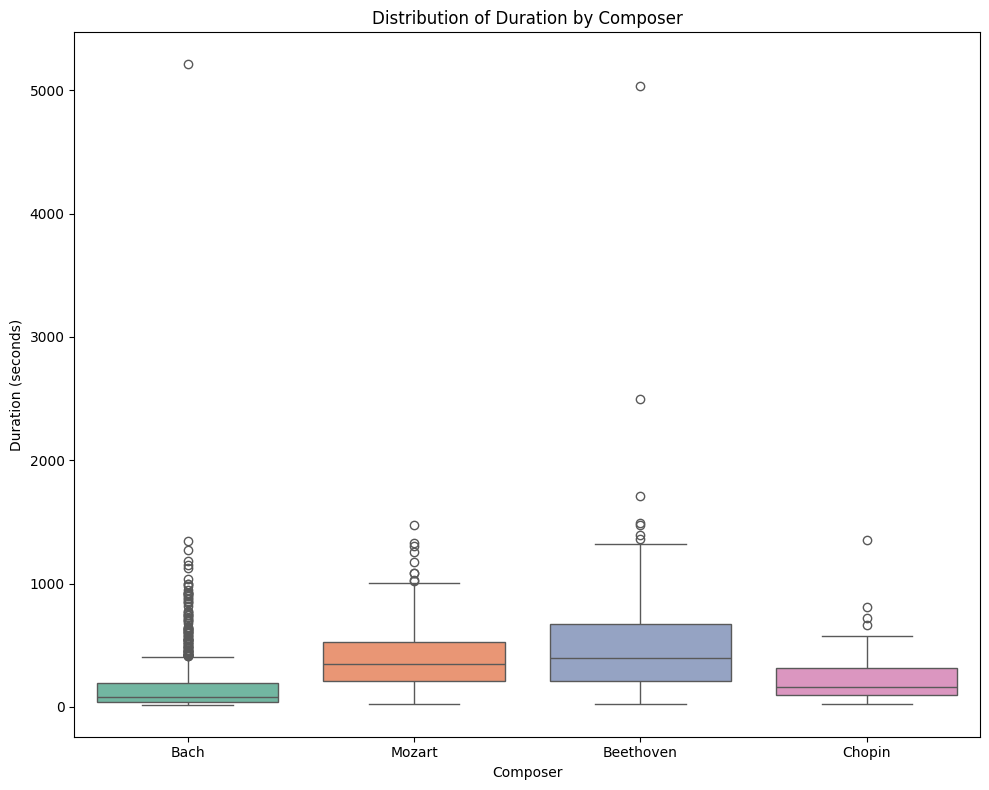

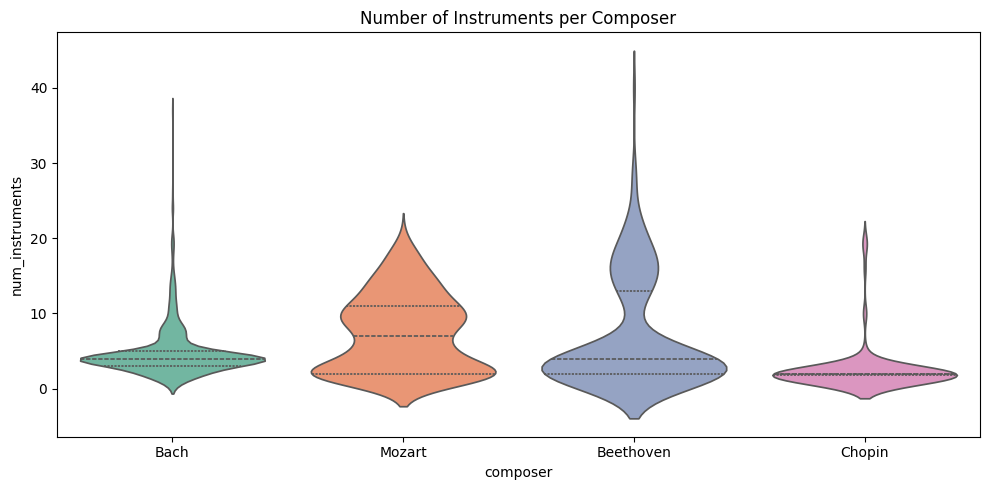

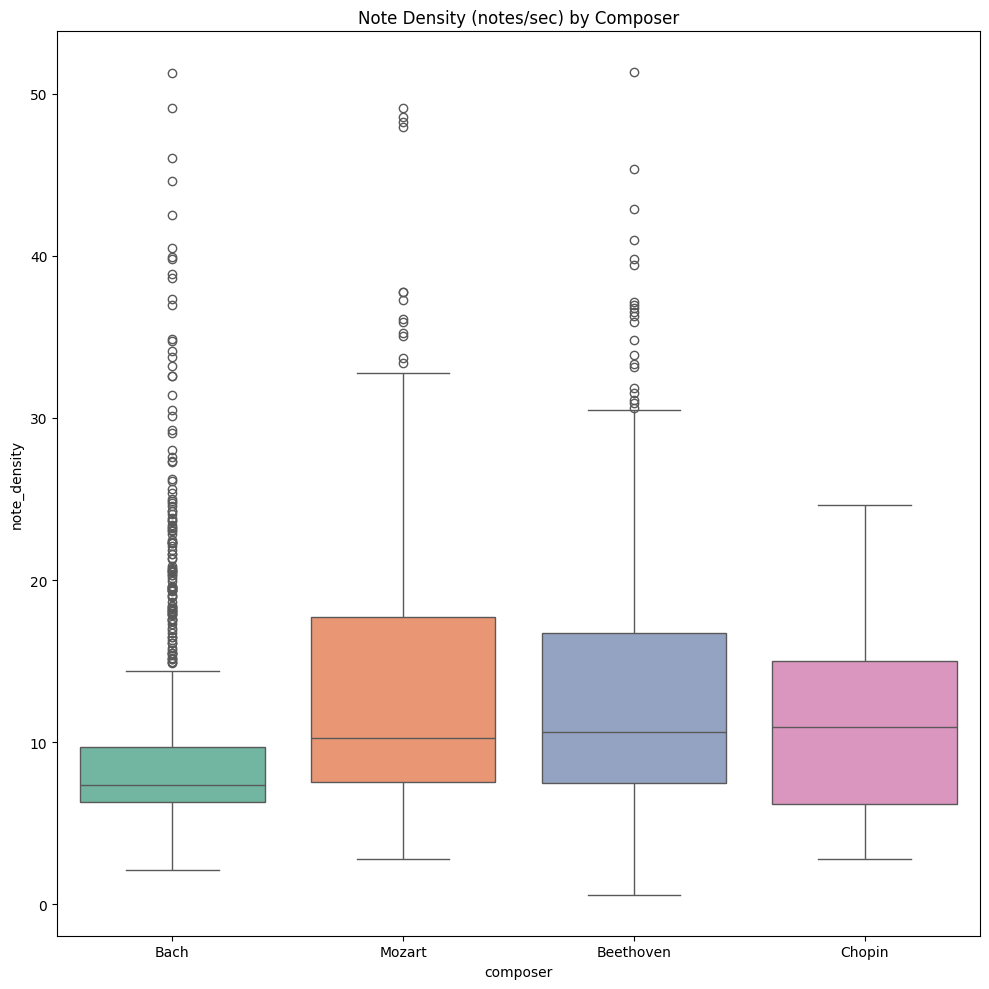

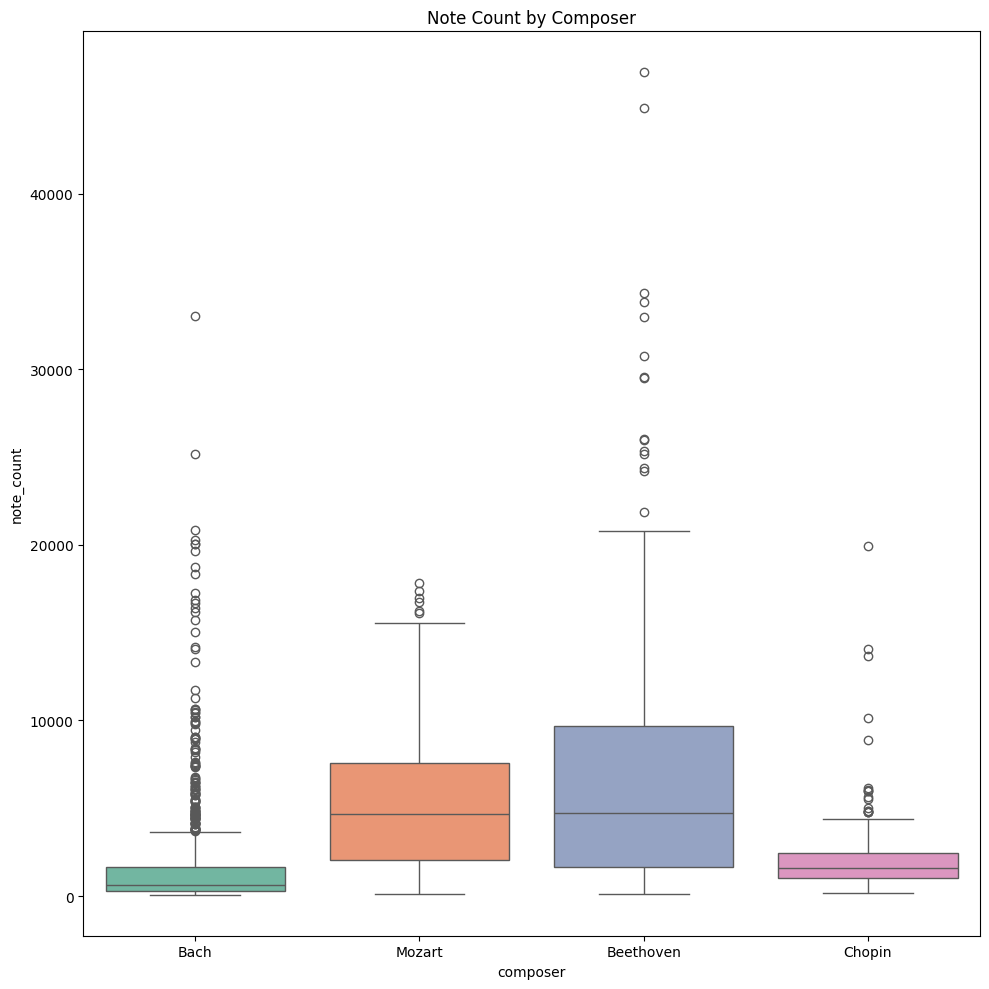

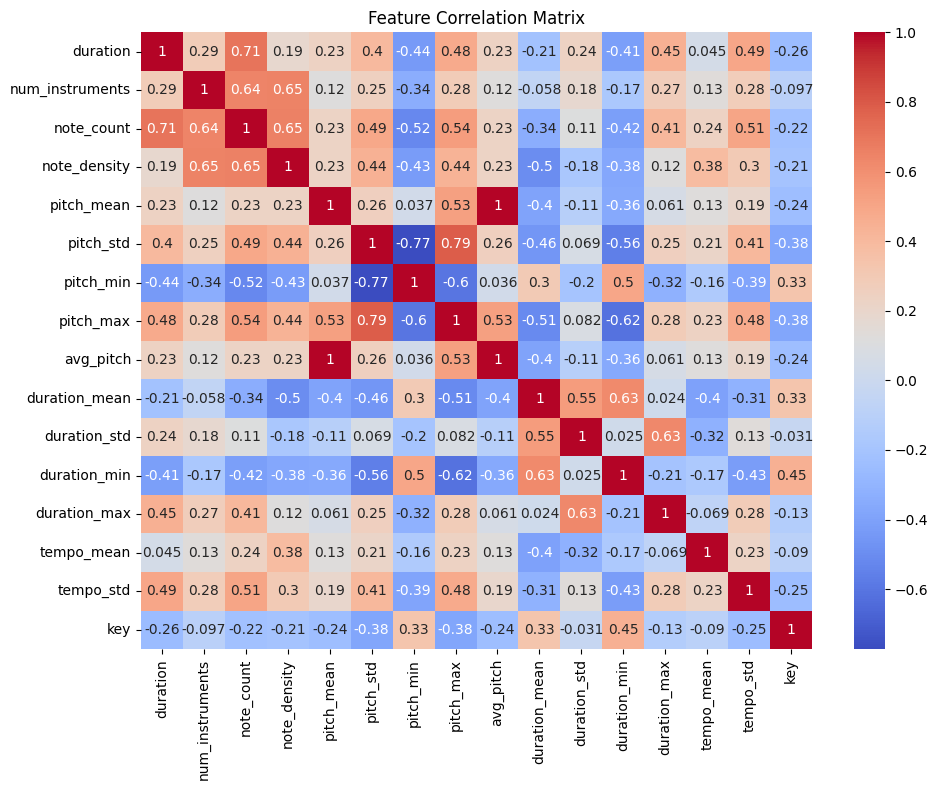

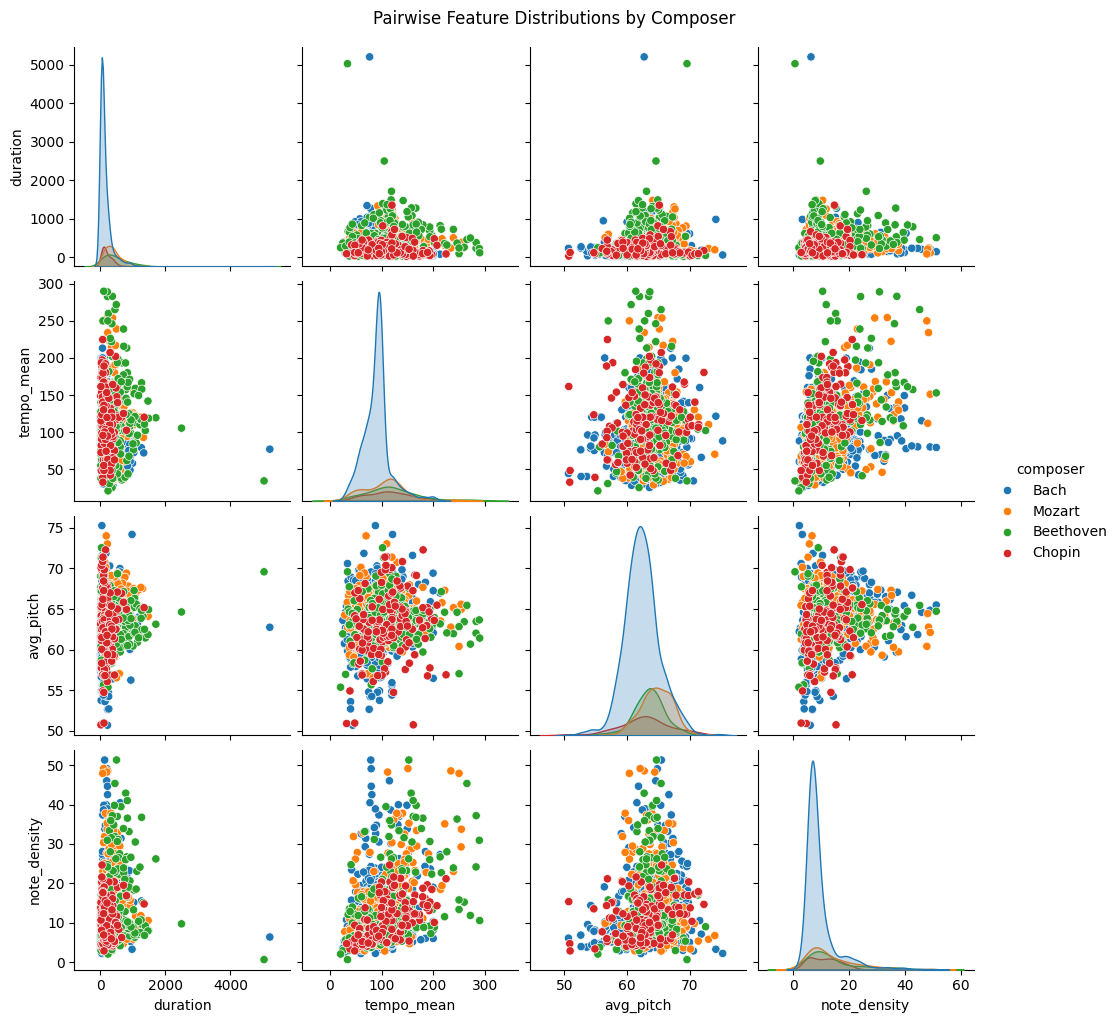

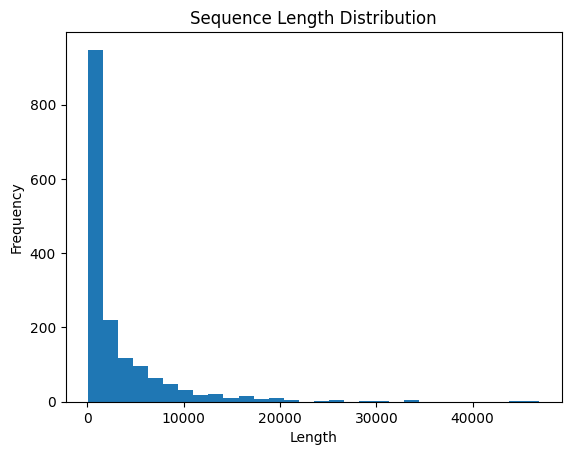

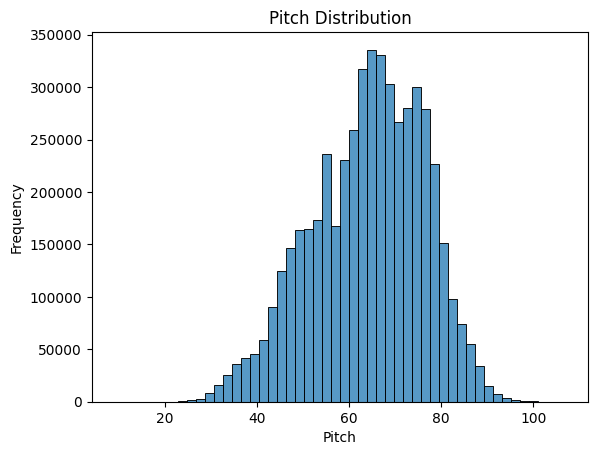

In [4]:
#@title Data Exploration Visuals

plt.figure(figsize=(10, 5))
sns.countplot(data=df, x="composer",  hue='composer', palette='Set2', legend=False)
plt.title("Number of MIDI Files per Composer")
plt.xlabel("Composer")
plt.ylabel("Number of Files")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x="composer", y="duration", hue='composer', palette='Set2', legend=False)
plt.title("Distribution of Duration by Composer")
plt.xlabel("Composer")
plt.ylabel("Duration (seconds)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
sns.violinplot(data=df, x="composer", y="num_instruments", inner="quartile", hue='composer', palette='Set2', legend=False)
plt.title("Number of Instruments per Composer")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
sns.boxplot(data=df, x='composer', y='note_density', hue='composer', palette='Set2', legend=False)
plt.title("Note Density (notes/sec) by Composer")
plt.tight_layout()
plt.show()

df['note_count'] = df['notes'].apply(len)
plt.figure(figsize=(10, 10))
sns.boxplot(data=df, x='composer', y='note_count', hue='composer', palette='Set2', legend=False)
plt.title("Note Count by Composer")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(df.drop(columns=["filename"]).corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

sns.pairplot(df, hue="composer", vars=["duration", "tempo_mean", "avg_pitch", "note_density"])
plt.suptitle("Pairwise Feature Distributions by Composer", y=1.02)
plt.show()

sequence_lengths = df['notes'].apply(len)
plt.hist(sequence_lengths, bins=30)
plt.title('Sequence Length Distribution')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

all_pitches = [pitch for seq in df['notes'] for pitch in seq]
sns.histplot(all_pitches, bins=50)
plt.title('Pitch Distribution')
plt.xlabel('Pitch')
plt.ylabel('Frequency')
plt.show()


#CNN Model

In [5]:
feature_cols = ['duration', 'num_instruments', 'note_count', 'note_density', 'pitch_mean',
                'pitch_std', 'pitch_min', 'pitch_max', 'avg_pitch', 'duration_mean',
                'duration_std', 'duration_min', 'duration_max', 'tempo_mean', 'tempo_std', 'key']

X_cnn = df[feature_cols].values

scaler = StandardScaler()
X_cnn = scaler.fit_transform(X_cnn)

le = LabelEncoder()
y_cnn = le.fit_transform(df['composer'])
y_cnn_cat = tf.keras.utils.to_categorical(y_cnn)

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(
    X_cnn, y_cnn_cat, test_size=0.2, stratify=y_cnn, random_state=42)


In [6]:
cnn_model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_cnn.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

history_cnn = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    validation_split=0.2,
    epochs=10,
    batch_size=8,
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,692 (41.77 KB)

 Trainable params: 10,692 (41.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.5355 - loss: 1.0804 - val_accuracy: 0.7203 - val_loss: 0.7585
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7262 - loss: 0.7243 - val_accuracy: 0.7548 - val_loss: 0.6760
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7670 - loss: 0.6765 - val_accuracy: 0.7586 - val_loss: 0.6256
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7847 - loss: 0.5708 - val_accuracy: 0.7548 - val_loss: 0.6273
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7753 - loss: 0.5644 - val_accuracy: 0.7701 - val_loss: 0.5888
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8187 - loss: 0.5045 - val_accuracy: 0.7701 - val_loss: 0.5759
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8172 - loss: 0.4830 - val_accuracy: 0.7663 - val_loss: 0.5957
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7941 - loss: 0.5181 - val_accuracy: 0

#LSTM Model

In [7]:
all_notes = [note for seq in df['notes'] for note in seq if note != 0]
unique_notes = sorted(set(all_notes))
note2idx = {note: idx + 1 for idx, note in enumerate(unique_notes)}  # padding = 0

max_len = 500

def encode_and_pad(seq):
    encoded = [note2idx[note] for note in seq[:max_len]]  # truncate if longer than max_len
    return encoded + [0] * (max_len - len(encoded))       # pad if shorter

X_seq = np.array(df['notes'].apply(encode_and_pad).tolist())
y_seq = le.transform(df['composer'])

X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, stratify=y_seq, random_state=42)

In [8]:
vocab_size = len(note2idx) + 1

lstm_model = models.Sequential([
    layers.Embedding(input_dim=vocab_size, output_dim=128, mask_zero=True, input_length=max_len),
    layers.LSTM(64),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(le.classes_), activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=10,
    batch_size=8,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.5964 - loss: 1.0839 - val_accuracy: 0.6169 - val_loss: 0.9223
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.6463 - loss: 0.9421 - val_accuracy: 0.6245 - val_loss: 0.9460
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6837 - loss: 0.8411 - val_accuracy: 0.6322 - val_loss: 0.8835
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6511 - loss: 0.8489 - val_accuracy: 0.6169 - val_loss: 0.8790
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7153 - loss: 0.7414 - val_accuracy: 0.6322 - val_loss: 0.8370
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.6984 - loss: 0.7488 - val_accuracy: 0.6513 - val_loss: 0.8171
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7365 - loss: 0.7115 - val_accuracy: 0.6437 - val_loss: 0.8545
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7401 - loss: 0.6642 - val_accu

# Evaluate Models

CNN Model Performance:
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
              precision    recall  f1-score   support

        Bach       0.85      0.96      0.90       205
   Beethoven       0.74      0.65      0.69        43
      Chopin       0.79      0.81      0.80        27
      Mozart       0.72      0.41      0.53        51

    accuracy                           0.82       326
   macro avg       0.77      0.71      0.73       326
weighted avg       0.81      0.82      0.81       326



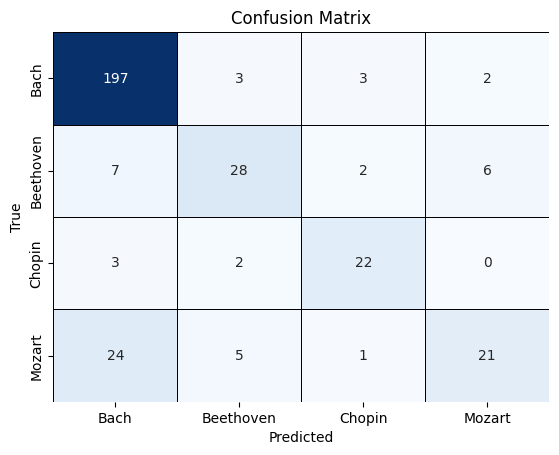

LSTM Model Performance:
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
              precision    recall  f1-score   support

        Bach       0.78      0.93      0.85       205
   Beethoven       0.37      0.30      0.33        43
      Chopin       0.41      0.33      0.37        27
      Mozart       0.42      0.22      0.29        51

    accuracy                           0.68       326
   macro avg       0.50      0.44      0.46       326
weighted avg       0.64      0.68      0.65       326



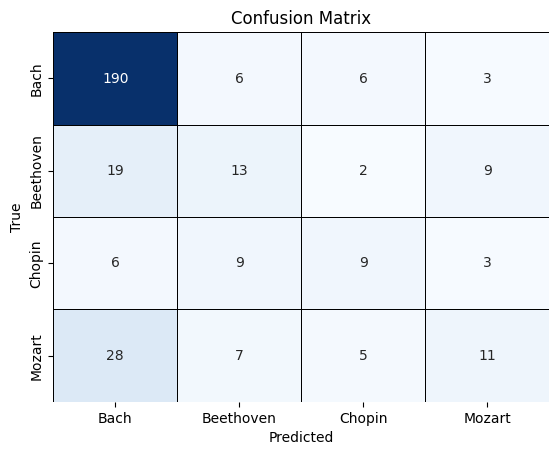

In [9]:
def evaluate_model(model, X_test, y_test, is_categorical=False):
    y_pred = model.predict(X_test)
    if is_categorical:
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_test, axis=1)
    else:
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_true = y_test

    print(classification_report(y_true, y_pred_labels, target_names=le.classes_))

    cm = confusion_matrix(y_true, y_pred_labels)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=le.classes_,
        yticklabels=le.classes_,
        cmap='Blues',
        cbar=False,
        linewidths=0.5,
        linecolor='black'
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

print("CNN Model Performance:")
evaluate_model(cnn_model, X_test_cnn, y_test_cnn, is_categorical=True)

print("LSTM Model Performance:")
evaluate_model(lstm_model, X_test_seq, y_test_seq, is_categorical=False)